In [1]:
# Cell 1 — Setup & Imports
# If needed in a fresh env:
# !pip install tensorflow==2.16.1 numpy scipy opencv-python pillow matplotlib tqdm

# <<< add to Cell 1 >>>
import tensorflow as tf
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")   # AMP on RTX 30/40 series
tf.config.optimizer.set_jit(True)                    # XLA on
print("Policy:", mixed_precision.global_policy())

import os, glob, math, random
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import scipy.io as sio
from scipy.ndimage import gaussian_filter
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

2025-09-26 21:19:44.790844: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 21:19:45.317812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758899985.492077    6175 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758899985.541905    6175 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758899985.967172    6175 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Policy: <DTypePolicy "mixed_float16">
TensorFlow: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# Cell 2 — Configuration & Reproducibility

# >>>>>>>>>>>> SET THIS TO YOUR EXTRACTED DATA FOLDER <<<<<<<<<<<<
DATA_ROOT = "/home/akif/Desktop/ComputerVision/Assignment_7/archive(5)/ShanghaiTech/part_B"   # e.g., "/kaggle/input/shanghaitech/part_B"

IMG_SIZE = (512,512)   # (H, W); try (512,512) for higher accuracy if GPU allows
SIGMA = 4.0             # Gaussian std for density map
BATCH_SIZE = 4
EPOCHS = 50
LR = 4e-4
NUM_PARALLEL = tf.data.AUTOTUNE
VAL_SPLIT = 0.0         # keep 0; we'll evaluate on test set

def set_seed(seed=2025):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(2025)

In [3]:
# <<< add to Cell 3 >>>
from scipy.spatial import cKDTree

def generate_density_adaptive(points_xy, h, w, k=3, beta=0.3, min_sigma=1.0, max_sigma=10.0):
    """
    Geometry-adaptive density: sigma_i = beta * mean distance to k nearest neighbors.
    """
    density = np.zeros((h, w), dtype=np.float32)
    if points_xy is None or len(points_xy) == 0:
        return density

    pts = points_xy.copy()
    pts[:,0] = np.clip(pts[:,0], 0, w-1)
    pts[:,1] = np.clip(pts[:,1], 0, h-1)

    if len(pts) == 1:
        sigmas = np.array([3.0], dtype=np.float32)
    else:
        tree = cKDTree(pts)
        dists, _ = tree.query(pts, k=min(k+1, len(pts)))  # includes self at 0
        if dists.shape[1] > 1:
            sigmas = beta * dists[:,1:].mean(axis=1)
        else:
            sigmas = np.full((len(pts),), 3.0, dtype=np.float32)
    sigmas = np.clip(sigmas, min_sigma, max_sigma)

    for (x, y), s in zip(pts, sigmas):
        xi, yi = int(round(x)), int(round(y))
        rad = int(3*s)
        x1, x2 = max(0, xi-rad), min(w-1, xi+rad)
        y1, y2 = max(0, yi-rad), min(h-1, yi+rad)
        if x2 < x1 or y2 < y1: 
            continue
        xs = np.arange(x1, x2+1) - x
        ys = np.arange(y1, y2+1) - y
        X, Y = np.meshgrid(xs, ys)
        g = np.exp(-(X*X + Y*Y)/(2*s*s)) / (2*np.pi*s*s)
        density[y1:y2+1, x1:x2+1] += g.astype(np.float32)
    return density

# Cell 3 — Utilities: read points from .mat and create density maps

def read_points_from_mat(mat_path):
    """
    Extract Nx2 points from a ShanghaiTech .mat file.
    Returns float32 array (N,2) in (x,y) order.
    """
    m = sio.loadmat(mat_path)
    if 'annPoints' in m:
        pts = np.array(m['annPoints'])
        if pts.ndim == 2 and pts.shape[1] == 2:
            pass
        elif pts.ndim == 2 and pts.shape[0] == 2:
            pts = pts.T
        else:
            pts = np.zeros((0,2), dtype=np.float32)
        return pts.astype(np.float32)

    if 'image_info' in m:
        info = m['image_info']
        try:
            pts = info[0,0][0,0][0]
        except Exception:
            try:
                pts = info[0,0]['location'][0,0]
            except Exception:
                pts = None
                for v in m.values():
                    if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 2:
                        pts = v; break
                if pts is None:
                    pts = np.zeros((0,2), dtype=np.float32)
        return np.asarray(pts, dtype=np.float32)

    for v in m.values():
        if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == 2:
            return v.astype(np.float32)
    return np.zeros((0,2), dtype=np.float32)


def generate_density_from_points(points_xy, h, w, sigma=4.0):
    """
    points_xy in (x,y) on target grid (w,h). Returns (h,w) float32 density.
    """
    density = np.zeros((h, w), dtype=np.float32)
    if points_xy is None or len(points_xy) == 0:
        return density
    xs = np.clip(np.round(points_xy[:,0]).astype(int), 0, w-1)
    ys = np.clip(np.round(points_xy[:,1]).astype(int), 0, h-1)
    density[ys, xs] = 1.0
    density = gaussian_filter(density, sigma=sigma, mode='constant')
    return density.astype(np.float32)

In [4]:
# Cell 4 — Generator supporting patches & adaptive density

class ShanghaiTechGenerator:
    def __init__(self, split_root, 
                 img_size=(256,256),              # used when patch_mode=False
                 sigma=4.0, 
                 augment=False,
                 patch_mode=False, 
                 patch_size=(512,512),
                 use_adaptive=True,               # <<< turn on adaptive labels
                 knn_k=3, beta=0.3):
        self.img_dir = Path(split_root) / "images"
        self.gt_dir  = Path(split_root) / "ground-truth"
        self.files = sorted(glob.glob(str(self.img_dir / "*.jpg")))
        self.img_size = img_size
        self.sigma = sigma
        self.augment = augment
        self.patch_mode = patch_mode
        self.patch_size = patch_size
        self.use_adaptive = use_adaptive
        self.knn_k = knn_k
        self.beta = beta

    def __len__(self):
        return len(self.files)

    def _load_rgb(self, p):
        return np.array(Image.open(p).convert("RGB"))

    def _make_density(self, pts, H, W):
        if self.use_adaptive:
            return generate_density_adaptive(pts, H, W, k=self.knn_k, beta=self.beta)
        else:
            return generate_density_from_points(pts, H, W, sigma=self.sigma)

    def __call__(self):
        for img_path in self.files:
            base = os.path.splitext(os.path.basename(img_path))[0]
            mat_path = self.gt_dir / f"GT_{base}.mat"

            img = self._load_rgb(img_path)   # HWC
            H0, W0 = img.shape[:2]
            pts = read_points_from_mat(str(mat_path))  # (N,2) in (x,y)

            if self.patch_mode:
                Hc, Wc = self.patch_size

                # Upscale if image is smaller than patch
                if H0 < Hc or W0 < Wc:
                    scale = max(Hc/H0, Wc/W0)
                    img = cv2.resize(img, (int(W0*scale)+1, int(H0*scale)+1), interpolation=cv2.INTER_CUBIC)
                    if pts.size > 0:
                        pts = pts.copy()
                        pts[:,0] *= scale; pts[:,1] *= scale
                    H0, W0 = img.shape[:2]

                # Random crop
                y0 = random.randint(0, H0 - Hc)
                x0 = random.randint(0, W0 - Wc)
                img_crop = img[y0:y0+Hc, x0:x0+Wc]

                if pts.size > 0:
                    mask = (pts[:,0]>=x0)&(pts[:,0]<x0+Wc)&(pts[:,1]>=y0)&(pts[:,1]<y0+Hc)
                    pts_sc = pts[mask].copy()
                    pts_sc[:,0] -= x0; pts_sc[:,1] -= y0
                else:
                    pts_sc = pts

                # Augment (HFlip + mild color jitter/blur)
                if self.augment:
                    if random.random() < 0.5:
                        img_crop = np.ascontiguousarray(img_crop[:, ::-1, :])
                        if pts_sc.size > 0:
                            pts_sc[:,0] = Wc - 1 - pts_sc[:,0]
                    if random.random() < 0.5:
                        img_crop = cv2.GaussianBlur(img_crop, (3,3), 0)
                    img_f = img_crop.astype(np.float32)/255.0
                    img_f = tf.image.random_brightness(img_f, 0.2)
                    img_f = tf.image.random_contrast(img_f, 0.8, 1.2)
                    img_crop = (np.clip(img_f.numpy(), 0, 1)*255).astype(np.uint8)

                den = self._make_density(pts_sc, Hc, Wc)
                img_t = img_crop.astype(np.float32)/255.0
                den_t = den[..., None].astype(np.float32)
                yield img_t, den_t, img_path

            else:
                # Resize mode (used for test)
                Ht, Wt = self.img_size
                sx, sy = Wt/W0, Ht/H0
                if pts.size > 0:
                    pts_sc = pts.copy()
                    pts_sc[:,0] *= sx; pts_sc[:,1] *= sy
                else:
                    pts_sc = pts
                img_r = cv2.resize(img, (Wt, Ht), interpolation=cv2.INTER_LINEAR)
                den = self._make_density(pts_sc, Ht, Wt)
                img_t = img_r.astype(np.float32)/255.0
                den_t = den[..., None].astype(np.float32)
                yield img_t, den_t, img_path

In [5]:
# Cell 5 — Build Datasets (patch train, resize test)
PATCH_SIZE = (512, 512) 
train_root = Path(DATA_ROOT) / "train_data"
test_root  = Path(DATA_ROOT) / "test_data"
assert train_root.exists()
assert test_root.exists()

# ---- TRAIN (patch mode, adaptive labels) ----
train_gen = ShanghaiTechGenerator(
    train_root, 
    augment=True,
    patch_mode=True,
    patch_size=PATCH_SIZE,
    use_adaptive=True,   # <<< adaptive sigma on train
    sigma=SIGMA
)

train_sig = (
    tf.TensorSpec(shape=(PATCH_SIZE[0], PATCH_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(PATCH_SIZE[0], PATCH_SIZE[1], 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.string),
)

ds_train = (tf.data.Dataset.from_generator(train_gen, output_signature=train_sig)
            .map(lambda x,y,p: (x,y), num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(1024)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

# ---- TEST (resize mode, adaptive labels for GT) ----
test_gen = ShanghaiTechGenerator(
    test_root, 
    img_size=IMG_SIZE,
    patch_mode=False,     # <<< resize mode
    use_adaptive=True,    # <<< adaptive GT on test for fair eval
    sigma=SIGMA
)

# --- after you create train_gen / test_gen ---

from math import floor


test_sig = (
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
    tf.TensorSpec(shape=(IMG_SIZE[0], IMG_SIZE[1], 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.string),
)

ds_test_full = tf.data.Dataset.from_generator(test_gen, output_signature=test_sig).prefetch(tf.data.AUTOTUNE)
ds_test      = ds_test_full.map(lambda x,y,p: (x,y)).batch(1).prefetch(tf.data.AUTOTUNE)

# How many batches per epoch to run (images // batch)
STEPS_PER_EPOCH = max(1, len(train_gen) // BATCH_SIZE)

ds_train = (
    tf.data.Dataset.from_generator(train_gen, output_signature=train_sig)
      .map(lambda x, y, p: (x, y), num_parallel_calls=tf.data.AUTOTUNE)
      .shuffle(1024)
      .repeat()                                  # <<< IMPORTANT: keep producing batches across epochs
      .batch(BATCH_SIZE, drop_remainder=True)    # drop the last partial to keep shapes stable under AMP/XLA
      .prefetch(tf.data.AUTOTUNE)
)

# test stays finite (no repeat)
ds_test_full = tf.data.Dataset.from_generator(test_gen, output_signature=test_sig).prefetch(tf.data.AUTOTUNE)
ds_test      = ds_test_full.map(lambda x,y,p: (x,y)).batch(1).prefetch(tf.data.AUTOTUNE)

print("Train images:", len(train_gen), "| Test images:", len(test_gen))
print("STEPS_PER_EPOCH:", STEPS_PER_EPOCH)


print("Train images:", len(train_gen), "| Test images:", len(test_gen))
print("Train batches/epoch (approx):", max(1, len(train_gen)//BATCH_SIZE))

I0000 00:00:1758899990.870948    6175 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5506 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


Train images: 400 | Test images: 316
STEPS_PER_EPOCH: 100
Train images: 400 | Test images: 316
Train batches/epoch (approx): 100


Example: /home/akif/Desktop/ComputerVision/Assignment_7/archive(5)/ShanghaiTech/part_B/test_data/images/IMG_1.jpg | resized: (512, 512, 3) | GT count: 21.88


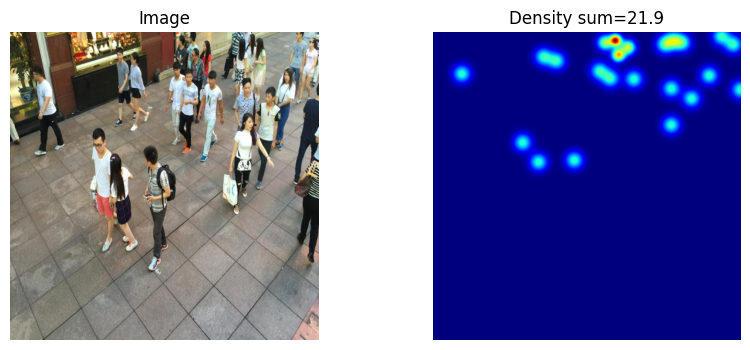

In [6]:
# Cell 6 — Sanity check: visualize one sample and its density/count

one_img, one_den, one_path = next(iter(ds_test_full.as_numpy_iterator()))
count = one_den.sum()
print("Example:", one_path.decode(), "| resized:", one_img.shape, "| GT count:", round(float(count),2))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(one_img); plt.title("Image"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(one_den.squeeze(), cmap="jet"); plt.title(f"Density sum={count:.1f}"); plt.axis("off")
plt.show()

In [7]:
# Cell 7 — Define a compact U-Net in Keras

def double_conv(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_unet(input_shape=(256,256,3), base=32, out_channels=1):
    inputs = keras.Input(shape=input_shape)
    # Down
    d1 = double_conv(inputs, base)
    p1 = layers.MaxPool2D()(d1)

    d2 = double_conv(p1, base*2)
    p2 = layers.MaxPool2D()(d2)

    d3 = double_conv(p2, base*4)
    p3 = layers.MaxPool2D()(d3)

    d4 = double_conv(p3, base*8)
    p4 = layers.MaxPool2D()(d4)

    bn = double_conv(p4, base*16)

    # Up
    u4 = layers.Conv2DTranspose(base*8, 2, strides=2, padding="same")(bn)
    u4 = layers.Concatenate()([u4, d4])
    u4 = double_conv(u4, base*8)

    u3 = layers.Conv2DTranspose(base*4, 2, strides=2, padding="same")(u4)
    u3 = layers.Concatenate()([u3, d3])
    u3 = double_conv(u3, base*4)

    u2 = layers.Conv2DTranspose(base*2, 2, strides=2, padding="same")(u3)
    u2 = layers.Concatenate()([u2, d2])
    u2 = double_conv(u2, base*2)

    u1 = layers.Conv2DTranspose(base, 2, strides=2, padding="same")(u2)
    u1 = layers.Concatenate()([u1, d1])
    u1 = double_conv(u1, base)

    # Non-negative density via ReLU
    # ... inside build_unet, replace the last two lines:

    raw_out = layers.Conv2D(out_channels, 1, padding="same")(u1)
    relu_out = layers.Activation("relu")(raw_out)
    outputs = layers.Lambda(lambda z: tf.cast(z, tf.float32), name="cast_fp32")(relu_out)
    
    return keras.Model(inputs, outputs, name="UNetSmall")

model = build_unet(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), base=32, out_channels=1)
model.summary()

Model: "UNetSmall"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512, 512,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 512, 512,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ re_lu_3[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_4[0][0]  

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [8]:
# Cell 8 — Custom callback to evaluate MAE/RMSE on test set each epoch and save best weights

class TestCountEvaluator(keras.callbacks.Callback):
    def __init__(self, test_dataset, save_path="unet_shtechB_best.weights.h5"):
        super().__init__()
        self.test_dataset = test_dataset
        self.best_mae = np.inf
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        mae, rmse = self.evaluate()
        logs = logs or {}
        logs["test_mae"] = mae
        logs["test_rmse"] = rmse
        print(f"\n[Eval] Epoch {epoch+1}: Test MAE={mae:.2f} | RMSE={rmse:.2f}")
        if mae < self.best_mae:
            self.best_mae = mae
            self.model.save_weights(self.save_path)
            print(f"[Eval] New best MAE. Weights saved to {self.save_path}")

    @tf.function
    def _sum(self, x):
        return tf.reduce_sum(x)

    def evaluate(self):
        ae_sum, se_sum, n = 0.0, 0.0, 0
        for batch_img, batch_den in self.test_dataset:
            pred = self.model(batch_img, training=False)
            pred_counts = tf.reduce_sum(pred, axis=[1,2,3]).numpy()
            true_counts = tf.reduce_sum(batch_den, axis=[1,2,3]).numpy()
            diff = pred_counts - true_counts
            ae_sum += np.abs(diff).sum()
            se_sum += (diff**2).sum()
            n += len(diff)
        mae = ae_sum / n
        rmse = math.sqrt(se_sum / n)
        return mae, rmse

evaluator = TestCountEvaluator(ds_test, save_path="unet_shtechB_best.weights.h5")

In [9]:
# Simple & stable optimizer/loss to get you training right away
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt, loss="mse")   # regression to density

history = model.fit(
    ds_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,  # <<< tell Keras when to stop each epoch
    callbacks=[evaluator],
    verbose=1
)

Epoch 1/50


I0000 00:00:1758899995.839387    6335 service.cc:152] XLA service 0x75b648002640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758899995.839403    6335 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1758899995.868631    6335 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758899995.988812    6335 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-09-26 21:20:08.525265: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:15,RepeatDataset:16): Filling up shuffle buffer (this may take a while): 808 of 1024
2025-09-26 21:20:11.067467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-09-26 21:20:11.294801: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPR

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0705

2025-09-26 21:20:55.554965: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-09-26 21:21:09.509084: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



[Eval] Epoch 1: Test MAE=91.49 | RMSE=130.28
[Eval] New best MAE. Weights saved to unet_shtechB_best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 77s 226ms/step - loss: 0.0242 - test_mae: 91.4863 - test_rmse: 130.2810
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 8.0559e-04
[Eval] Epoch 2: Test MAE=255.96 | RMSE=276.92
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - loss: 5.9500e-04 - test_mae: 255.9642 - test_rmse: 276.9219
Epoch 3/50
  3/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 1.9878e-04

2025-09-26 21:21:31.332465: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 2.4194e-04
[Eval] Epoch 3: Test MAE=363.06 | RMSE=381.19
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - loss: 2.1399e-04 - test_mae: 363.0558 - test_rmse: 381.1862
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.2003e-04
[Eval] Epoch 4: Test MAE=174.10 | RMSE=191.51
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - loss: 1.1041e-04 - test_mae: 174.0959 - test_rmse: 191.5123
Epoch 5/50
  3/100 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.6594e-05

2025-09-26 21:22:13.662416: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 7.1058e-05
[Eval] Epoch 5: Test MAE=85.58 | RMSE=103.69
[Eval] New best MAE. Weights saved to unet_shtechB_best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - loss: 6.8173e-05 - test_mae: 85.5769 - test_rmse: 103.6852
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.0067e-05
[Eval] Epoch 6: Test MAE=64.28 | RMSE=92.97
[Eval] New best MAE. Weights saved to unet_shtechB_best.weights.h5
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - loss: 4.3076e-05 - test_mae: 64.2818 - test_rmse: 92.9748
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.1585e-05
[Eval] Epoch 7: Test MAE=65.60 | RMSE=101.76
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 3.2543e-05 - test_mae: 65.5982 - test_rmse: 101.7599
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.2434e-05
[Eval] Epoch 8: Test MAE=72.30 | RMSE=112.07
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 2.2014e-05 - test_mae: 72.3022 - test_rmse: 

2025-09-26 21:23:37.869028: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.4358e-05
[Eval] Epoch 9: Test MAE=79.86 | RMSE=119.97
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 2.1306e-05 - test_mae: 79.8629 - test_rmse: 119.9707
Epoch 10/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.8448e-05
[Eval] Epoch 10: Test MAE=86.10 | RMSE=125.43
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 1.6099e-05 - test_mae: 86.1029 - test_rmse: 125.4291
Epoch 11/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.1607e-05
[Eval] Epoch 11: Test MAE=92.37 | RMSE=130.62
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 1.1513e-05 - test_mae: 92.3651 - test_rmse: 130.6230
Epoch 12/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.2370e-05
[Eval] Epoch 12: Test MAE=96.72 | RMSE=134.09
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 9.6433e-06 - test_mae: 96.7154 - test_rmse: 134.0868
Epoch 13/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8.9690e-06
[Eval] Epoch 13: Test MAE=99.98 | RMSE=136.6

2025-09-26 21:26:21.190197: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.8801e-06
[Eval] Epoch 17: Test MAE=108.44 | RMSE=143.34
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - loss: 5.0080e-06 - test_mae: 108.4422 - test_rmse: 143.3400
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 4.4167e-06
[Eval] Epoch 18: Test MAE=109.96 | RMSE=144.56
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 4.6458e-06 - test_mae: 109.9633 - test_rmse: 144.5598
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.5567e-06
[Eval] Epoch 19: Test MAE=110.32 | RMSE=144.85
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 4.7037e-06 - test_mae: 110.3152 - test_rmse: 144.8512
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 5.0858e-06
[Eval] Epoch 20: Test MAE=111.21 | RMSE=145.50
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - loss: 4.6473e-06 - test_mae: 111.2099 - test_rmse: 145.5044
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 3.6878e-06
[Eval] Epoch 21: Test MAE=112.98 | 

2025-09-26 21:31:47.700060: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.2538e-06
[Eval] Epoch 33: Test MAE=117.88 | RMSE=150.84
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 1.4374e-06 - test_mae: 117.8843 - test_rmse: 150.8374
Epoch 34/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.3854e-06
[Eval] Epoch 34: Test MAE=118.02 | RMSE=150.95
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - loss: 1.3839e-06 - test_mae: 118.0164 - test_rmse: 150.9467
Epoch 35/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.2232e-06
[Eval] Epoch 35: Test MAE=118.28 | RMSE=151.16
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 1.2244e-06 - test_mae: 118.2848 - test_rmse: 151.1621
Epoch 36/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.0792e-06
[Eval] Epoch 36: Test MAE=118.44 | RMSE=151.29
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 207ms/step - loss: 1.0926e-06 - test_mae: 118.4392 - test_rmse: 151.2912
Epoch 37/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1.1627e-06
[Eval] Epoch 37: Test MAE=118.60 | 

In [10]:
# Cell 10 — Load best weights and run final evaluation on test set

model.load_weights("unet_shtechB_best.weights.h5")

# Final MAE/RMSE
ae_sum, se_sum, n = 0.0, 0.0, 0
for img, den in ds_test:
    pred = model(img, training=False)
    pc = float(tf.reduce_sum(pred))
    gc = float(tf.reduce_sum(den))
    diff = pc - gc
    ae_sum += abs(diff)
    se_sum += diff**2
    n += 1
final_mae = ae_sum / n
final_rmse = math.sqrt(se_sum / n)
print(f"Final Test — MAE: {final_mae:.2f} | RMSE: {final_rmse:.2f}")

Final Test — MAE: 64.28 | RMSE: 92.97


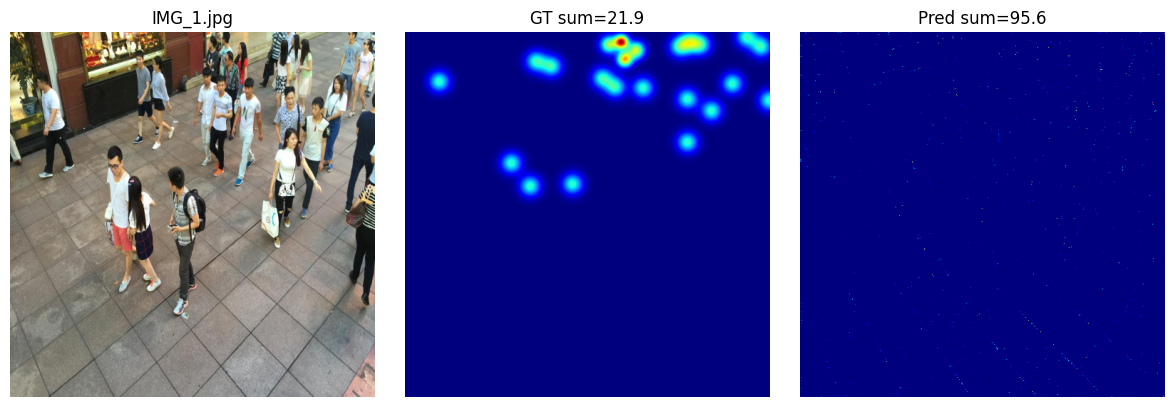

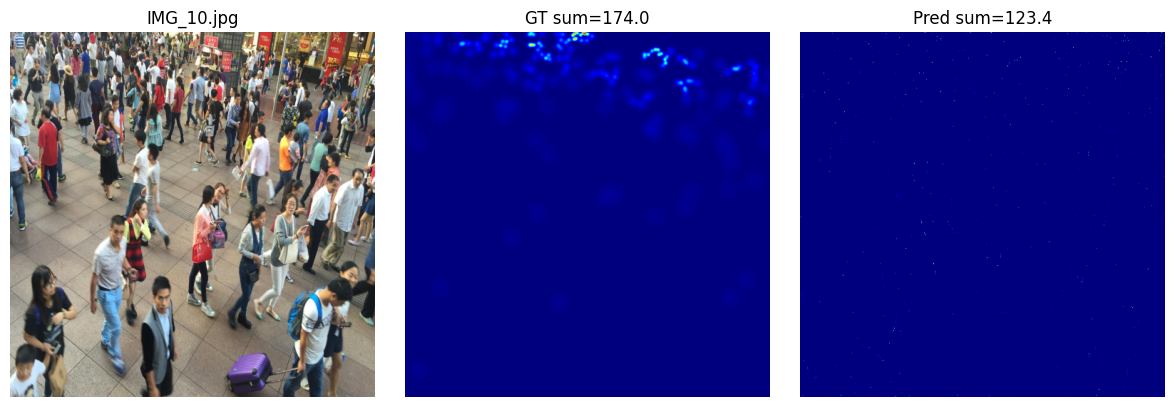

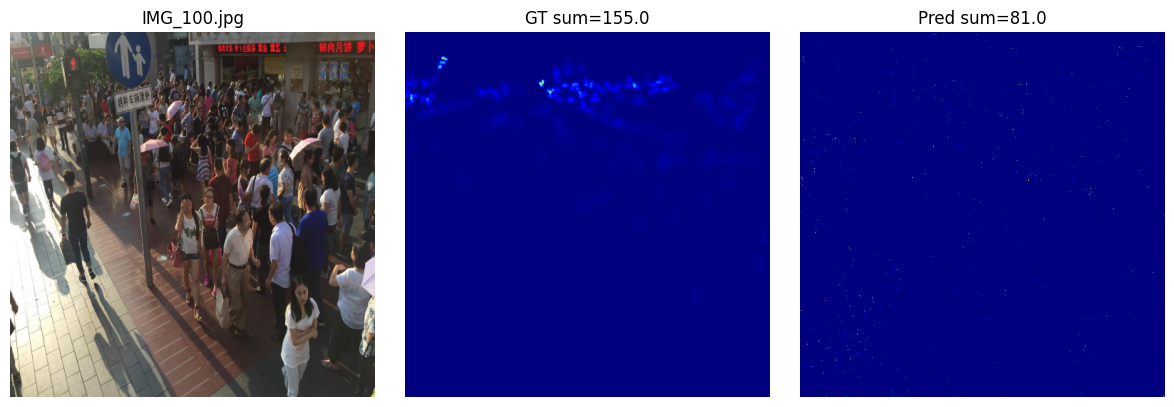

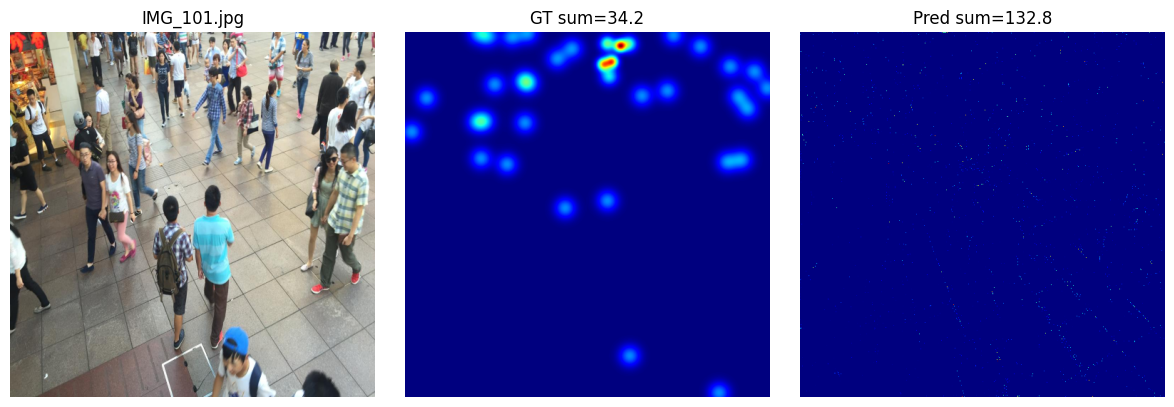

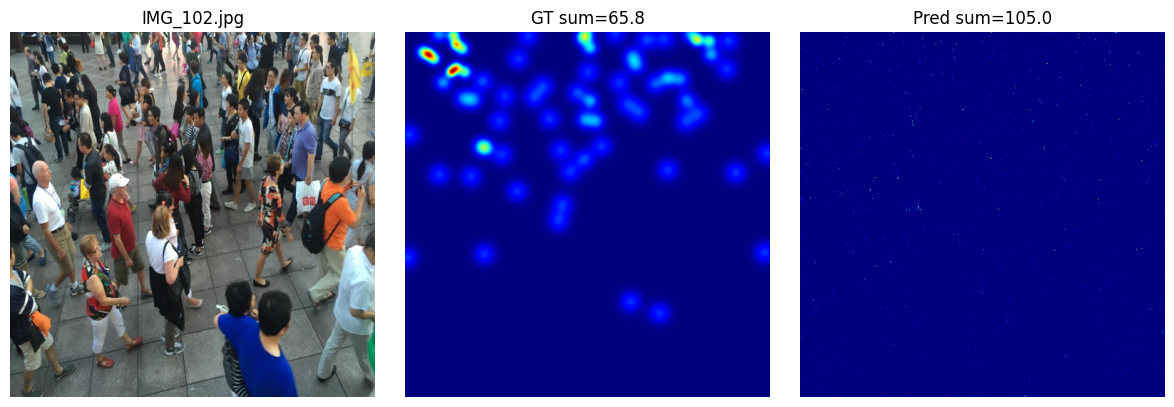

In [11]:
# Cell 11 — Visualize predictions vs ground-truth for a few test images

def visualize_examples(model, ds_full, num_examples=5, save_dir="pred_vis_tf"):
    os.makedirs(save_dir, exist_ok=True)
    shown = 0
    for img, den, path in ds_full:
        pred = model(img[None,...], training=False)[0].numpy()
        gt   = den.numpy()
        im   = (img.numpy()*255).astype(np.uint8)
        pc   = pred.sum(); gc = gt.sum()
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.imshow(im); plt.title(Path(path.numpy().decode()).name); plt.axis("off")
        plt.subplot(1,3,2); plt.imshow(gt.squeeze(), cmap="jet"); plt.title(f"GT sum={gc:.1f}"); plt.axis("off")
        plt.subplot(1,3,3); plt.imshow(pred.squeeze(), cmap="jet"); plt.title(f"Pred sum={pc:.1f}"); plt.axis("off")
        out = os.path.join(save_dir, f"{Path(path.numpy().decode()).stem}_viz.png")
        plt.tight_layout(); plt.savefig(out); plt.show()
        shown += 1
        if shown >= num_examples: break

visualize_examples(model, ds_test_full, num_examples=5)

In [12]:
# Cell 12 — Inference helper: get predicted count for any image path

def predict_count(image_path, model, img_size=IMG_SIZE):
    img = np.array(Image.open(image_path).convert("RGB"))
    Ht, Wt = img_size
    img_r = cv2.resize(img, (Wt, Ht), interpolation=cv2.INTER_LINEAR).astype(np.float32)/255.0
    pred = model.predict(img_r[None,...], verbose=0)[0]
    return float(pred.sum())

# Example:
# any_test_img = sorted(glob.glob(str(test_root / "images/*.jpg")))[0]
# print("Predicted count:", predict_count(any_test_img, model))

In [13]:
# # Cell 13 — Save final model (weights and full SavedModel)

# model.save_weights("unet_shtechB_final.weights.h5")
# model.save("unet_shtechB_savedmodel")  # SavedModel directory
# print("Saved weights and SavedModel.")

In [14]:
# # Cell 14 — Tips to improve accuracy (notes)

# tips = """
# 1) Train longer (50–150 epochs) and/or use cosine LR schedule; try LR warmup.
# 2) Increase resolution to 512×512 or train on random 256×256 patches cropped from higher-res images.
# 3) Use geometry-adaptive kernels (k-NN based sigma) instead of fixed sigma=4.
# 4) Add stronger augmentation: random crops, brightness/contrast jitter, mild Gaussian blur.
# 5) Combine L1 and MSE on density maps; ensure non-negativity (we use ReLU on output).
# 6) Use a deeper U-Net (base=64) or a lightweight backbone encoder (e.g., MobileNetV2) as feature extractor.
# """
# print(tips)